In [22]:
import Pkg
using ClimaAnalysis
using EnsembleKalmanProcesses
using CairoMakie
using Statistics
using JLD2

7-element Vector{String}:
 "0"
 "500"
 "1000"
 "1500"
 "2000"
 "2500"
 "3000"

(size(ta.data))[1] = 303


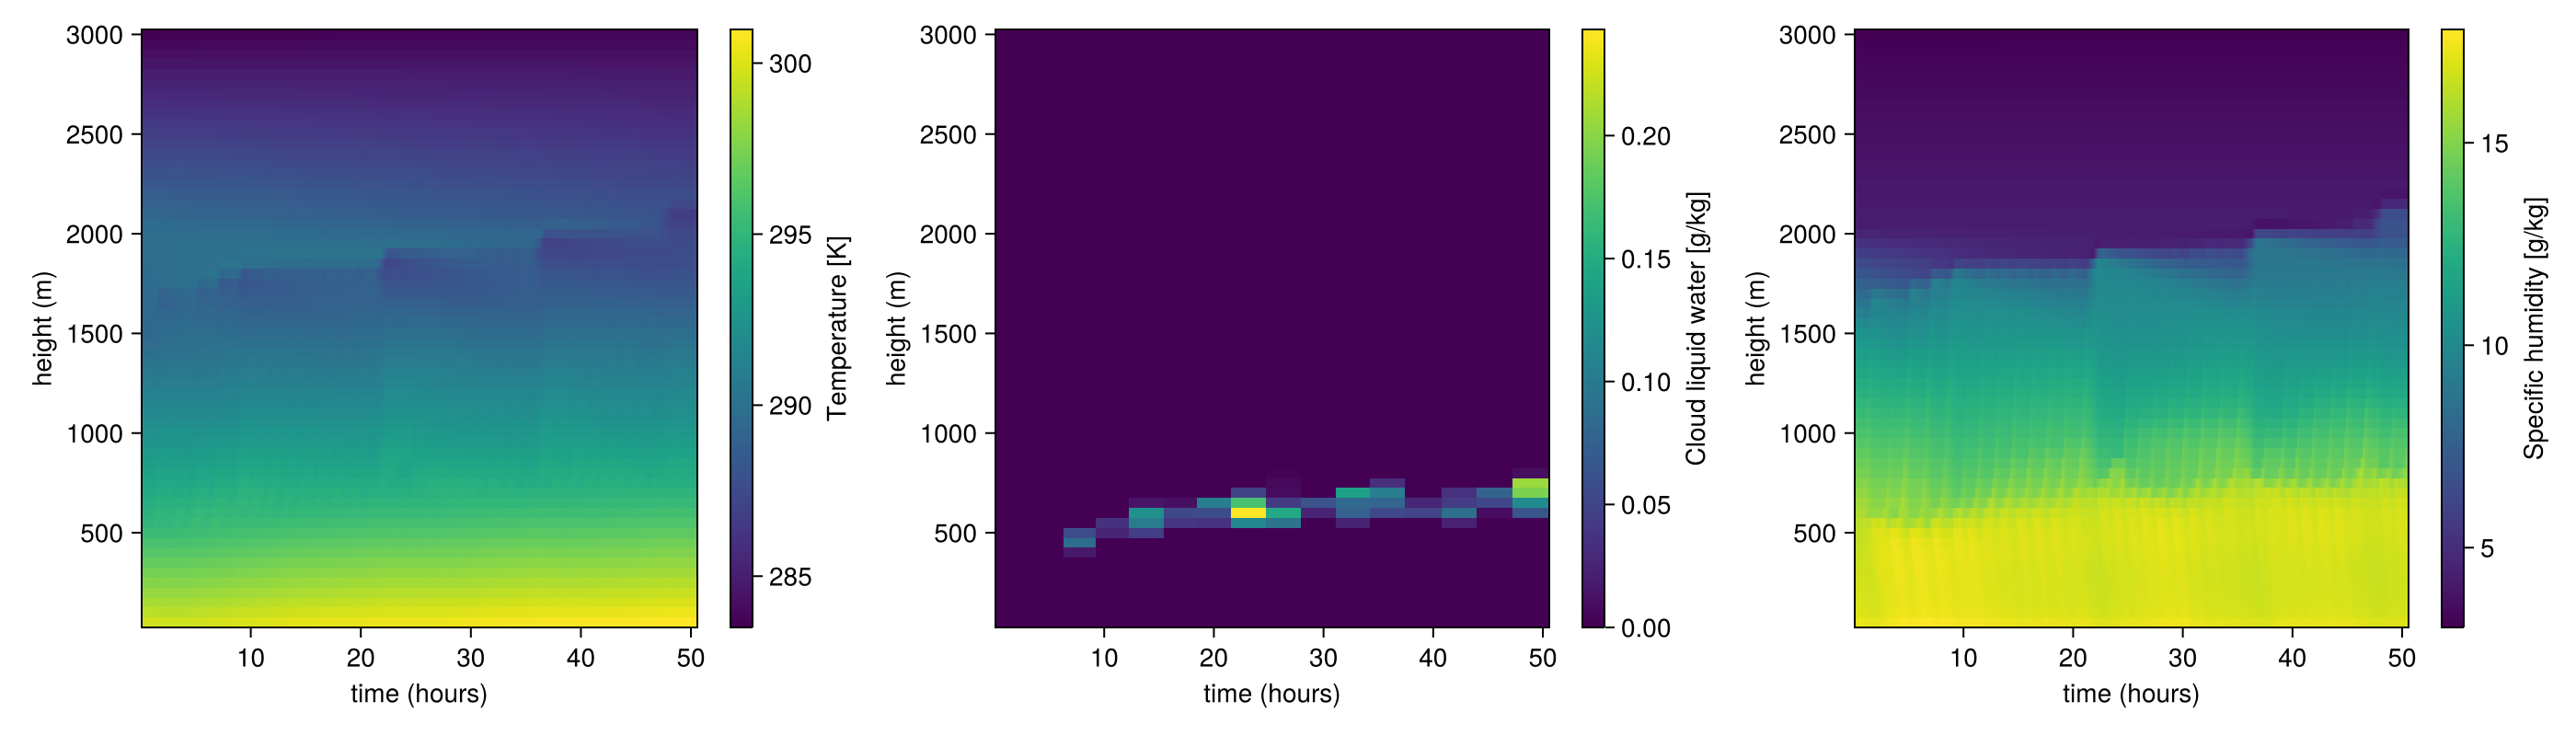

In [264]:
# read in observational data 
simdir = SimDir(joinpath("output", "prognostic_edmfx_bomex_column", "output_active"))
#println(summary(simdir))
ta = get(simdir; short_name = "ta",  period = "10m")
# check shape 
@show size(ta.data)[1]
cl = get(simdir; short_name = "cl", period = "10m")
clw = get(simdir; short_name = "clw", period = "10m")
hus = get(simdir; short_name = "hus", period = "10m")
# waup = get(simdir; short_name = "waup", reduction = "average", period = "1d")
# clwup = get(simdir; short_name = "clwup", reduction = "average", period = "1d")
fig = Figure(size=(1400, 400))
ax = Axis(fig[1, 1], xlabel = "time (hours)", ylabel = "height (m)", 
            yticks = (0:10:60, string.(Integer.(collect(0:3e3/6:3e3)))),
            xticks = (0:60:300, string.(Integer.(collect(0:60*10/60:300*10/60)))))
# ax.yticks = 1:60
# ax.ytickformat = 0:3e3/60:3e3

hm = heatmap!(ta.data[:, 1, 1, :])
Colorbar(fig[:, 1+1], hm, label = "Temperature [K]")

ax2 = Axis(fig[1, 3], xlabel = "time (hours)", ylabel = "height (m)", 
            yticks = (0:10:60, string.(Integer.(collect(0:3e3/6:3e3)))),
            xticks = (0:60:300, string.(Integer.(collect(0:60*10/60:300*10/60)))))
hm2 = heatmap!(clw.data[:, 1, 1, :] .* 1000)
Colorbar(fig[:, 3+1], hm2, label = "Cloud liquid water [g/kg]")

ax3 = Axis(fig[1, 5], xlabel = "time (hours)", ylabel = "height (m)", 
            yticks = (0:10:60, string.(Integer.(collect(0:3e3/6:3e3)))),
            xticks = (0:60:300, string.(Integer.(collect(0:60*10/60:300*10/60)))))
hm3 = heatmap!(hus.data[:, 1, 1, :] .* 1000)
Colorbar(fig[:, end+1], hm3, label = "Specific humidity [g/kg]")

save("plots/data_profiles.png", fig)
fig


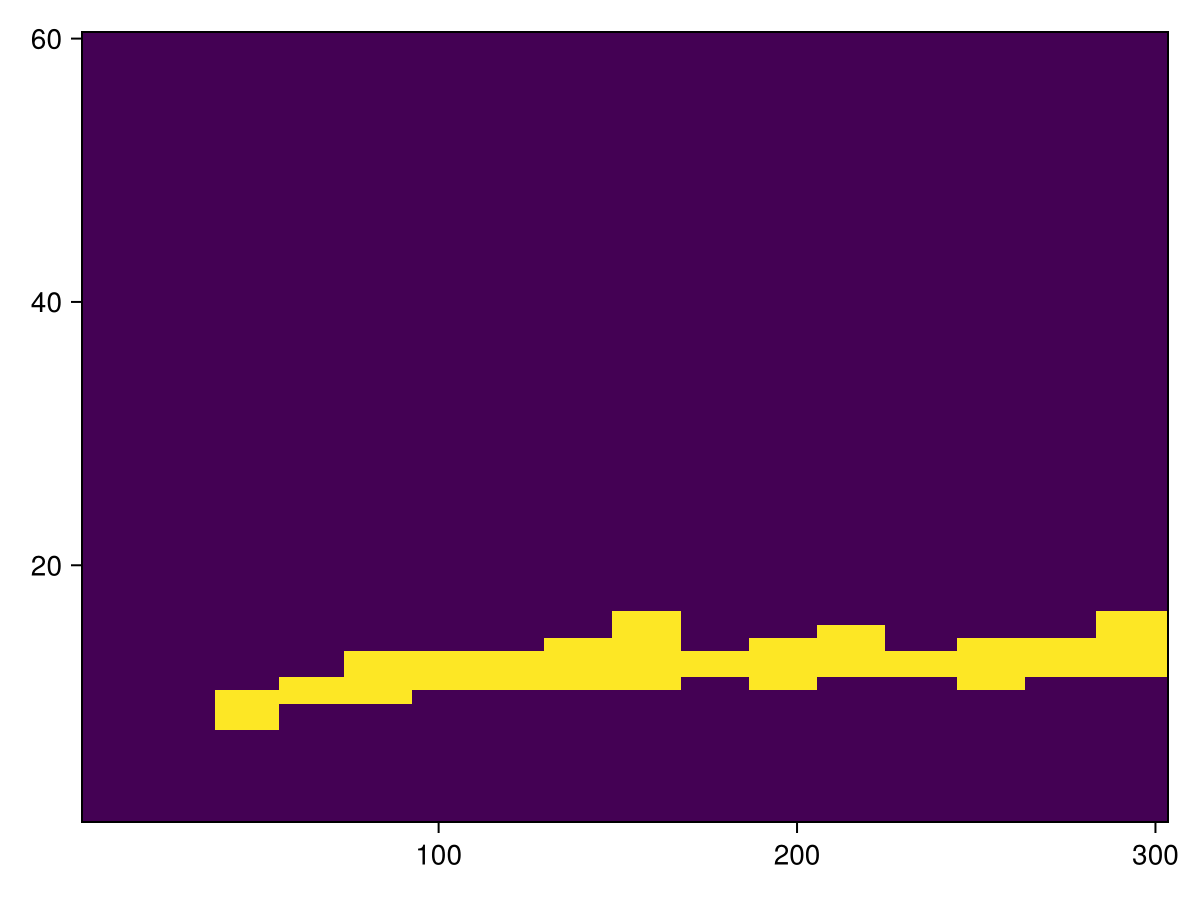

In [198]:
heatmap(cl.data[:, 1, 1, :])

In [140]:
# read in ensemble data
cases =  filter(readdir("output")) do x
    occursin("obs", x) && occursin("001", x) 
end
file_paths = ["output/$x/2param_calibration.jld2" for x in cases]
true_params = [0.3, 0.14]

2-element Vector{Float64}:
 0.3
 0.14

In [141]:
vars = map(sim_id -> split(sim_id, "_")[2], cases)
learning_rate = map(sim_id -> split(sim_id, "_")[3], cases)
println(vars)
println(learning_rate)

SubString{String}["cl", "clw", "hus", "ta", "ta", "ua", "va", "wa"]
SubString{String}["0.001", "0.001", "0.001", "0.0001", "0.001", "0.001", "0.001", "0.001"]


In [142]:

dat = mean(JLD2.load(file_paths[1])["ar"][2], dims = 1)

1×4 Matrix{Float64}:
 0.208863  0.172415  0.18789  0.172475

In [143]:
dat

1×4 Matrix{Float64}:
 0.208863  0.172415  0.18789  0.172475

In [144]:
function bias_and_mse(file_path, true_params, index)
    data = JLD2.load(file_path)["ar"][index] .- true_params[index]
    bias = mean(data, dims = 1)
    mse = sqrt.(mean(data.^2, dims = 1))
    return bias, mse
end

bias_mse = map(file_path -> bias_and_mse(file_path, true_params, 1), file_paths)
println(bias_mse)

[([0.13130776256800725 -0.03157091115620088 -0.028863726642843972 0.010620436780149622], [0.17147817060914844 0.044261912475737235 0.034152178613007345 0.011227685342953988]), ([0.13130776256800725 0.052353149817852385 0.24602084500064686 0.30094193722797724], [0.17147817060914844 0.07797157978968354 0.246800824205123 0.30119270447969365]), ([0.13130776256800725 0.0037711442879542595 -0.008834342841102889 0.0013661499314086873], [0.17147817060914844 0.022125207194543334 0.019603945046338434 0.014724531829875626]), ([0.13130776256800725 -0.08210243150658106 -0.09906849481697708 -0.10803026528508076], [0.17147817060914844 0.0872547832569284 0.0995865939918287 0.10811646668939649]), ([0.13130776256800725 -0.018266063053277454 -0.04671100780665012 -0.06586009328179447], [0.17147817060914844 0.05328805867461224 0.050824892552913926 0.06727889255759309]), ([0.13130776256800725 0.030676964514375665 0.013365487755400831 0.0055917040224821735], [0.17147817060914844 0.0363118981246992 0.01625315

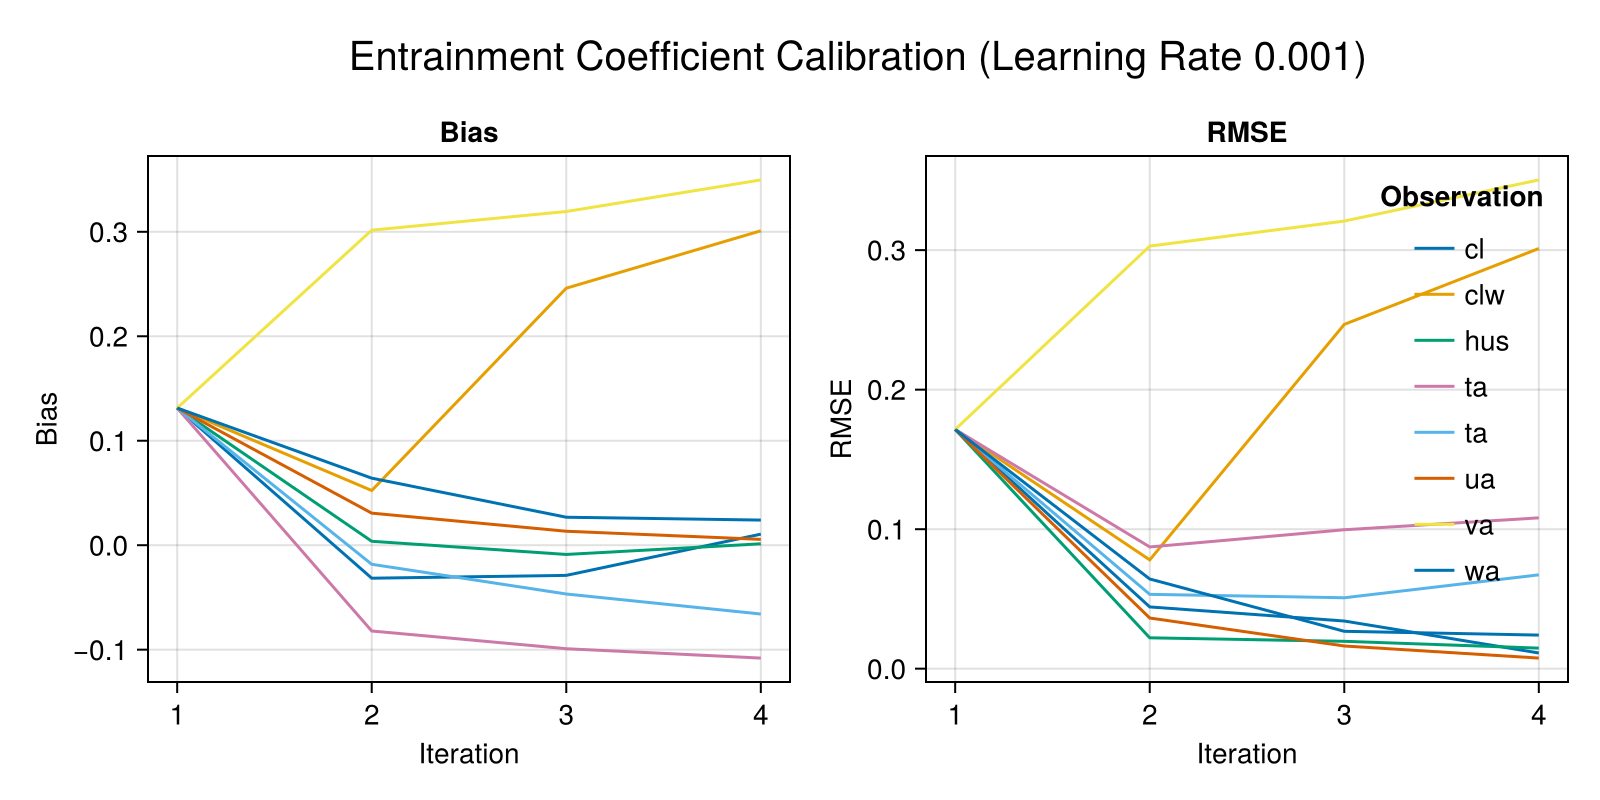

In [151]:
# plot the bias and mse in subplots 
fig = Figure(size = (800, 400))
ax1 = Axis(fig[1, 1], title = "Bias", xlabel = "Iteration", ylabel = "Bias")
ax2 = Axis(fig[1, 2], title = "RMSE", xlabel = "Iteration", ylabel = "RMSE")

for i in 1:length(file_paths)
    bias, mse = bias_mse[i]
    lines!(ax1, vec(bias), colormap= :tab20)
    lines!(ax2, vec(mse), label = "$(vars[i])", colormap=:tab20)
end
# add legend to the plot
axislegend(ax2, "Observation", framevisible = false, position = :rt)

Label(fig[0,:], "Entrainment Coefficient Calibration (Learning Rate $(learning_rate[1]))", fontsize = 20)

CairoMakie.save("plots/entrainment_rate_calibration_$(learning_rate[1]).png", fig)
fig

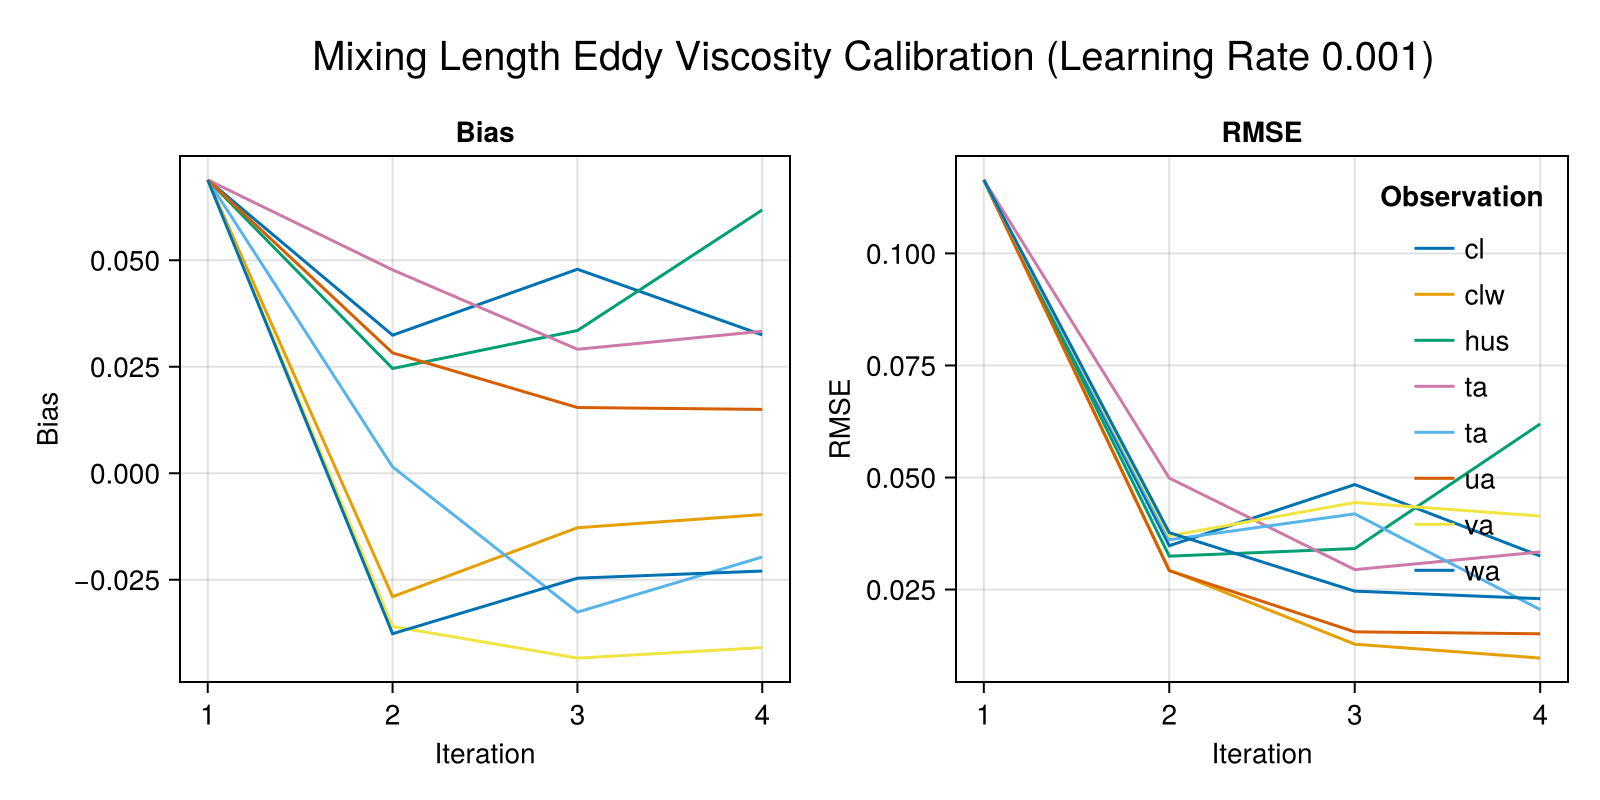

In [150]:
# plot the bias and mse in subplots 
bias_mse2 = map(file_path -> bias_and_mse(file_path, true_params, 2), file_paths)

fig = Figure(size = (800, 400))
ax1 = Axis(fig[1, 1], title = "Bias", xlabel = "Iteration", ylabel = "Bias")
ax2 = Axis(fig[1, 2], title = "RMSE", xlabel = "Iteration", ylabel = "RMSE")

for i in 1:length(file_paths)
    bias, mse = bias_mse2[i]
    lines!(ax1, vec(bias), colormap= :tab20)
    lines!(ax2, vec(mse), label = "$(vars[i])", colormap=:tab20)
end
# add legend to the plot
axislegend(ax2, "Observation", framevisible = false, position = :rt)

Label(fig[0,:], "Mixing Length Eddy Viscosity Calibration (Learning Rate $(learning_rate[1]))", fontsize = 20)
CairoMakie.save("plots/eddy_viscosity_calibration_$(learning_rate[1]).png", fig)
fig

In [132]:
# evaluate ta calibrations across noise functions, since normalized we expect to be the same
# read in files as before and filter for ta in string as well
cases =  filter(readdir("output")) do x
    occursin("ta", x)
end
# repeat getting data for each 
file_paths = ["output/$x/2param_calibration.jld2" for x in cases]
true_params = [0.3, 0.14]
bias_mse_ta = map(file_path -> bias_and_mse(file_path, true_params, 1), file_paths)


5-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([0.13130776256800725 -0.08210243150658106 -0.09906849481697708 -0.10803026528508076], [0.17147817060914844 0.0872547832569284 0.0995865939918287 0.10811646668939649])
 ([0.13130776256800725 -0.018266063053277454 -0.04671100780665012 -0.06586009328179447], [0.17147817060914844 0.05328805867461224 0.050824892552913926 0.06727889255759309])
 ([0.13130776256800725 0.017556865778821023 -0.031619492086449326 -0.053400457287686186], [0.17147817060914844 0.06784051453987826 0.054870728048566596 0.06006282258517407])
 ([0.13130776256800725 0.08437279090627811 0.025102020783006457 0.013166027144563235], [0.17147817060914844 0.12969523164964322 0.07271241131926905 0.06138756365034909])
 ([0.13130776256800725 0.10653454671316141 0.06652900886464358 0.05748920503943507], [0.17147817060914844 0.15083471423809397 0.10842362105098122 0.09844528471470713])

In [137]:
fig = Figure(size = (800, 400))
ax1 = Axis(fig[1, 1], title = "Bias", xlabel = "Iteration", ylabel = "Bias")
ax2 = Axis(fig[1, 2], title = "RMSE", xlabel = "Iteration", ylabel = "RMSE")

for i in 1:length(file_paths)
    bias, mse = bias_mse_ta[i]
    lines!(ax1, vec(bias))
    lines!(ax2, vec(mse), label = "$(split(cases[i], "_")[3])")
end
# add legend to the plot
axislegend(ax2, "Learning Rate", framevisible = false, position = :rt)

Label(fig[0,:], "Learning Rate Effect (observing temperature)", fontsize = 20)
fig
CairoMakie.save("plots/learning_rate_effect.png", fig)

CairoMakie.Screen{IMAGE}


In [4]:
t = JLD2.load("output/adpt_ta/iteration_000/G_ensemble.jld2")["single_stored_object"]

60×7 Matrix{Float64}:
 300.411  300.536  300.495  300.496  300.458  300.45   300.529
 299.912  300.043  299.999  300.0    299.962  299.956  300.039
 299.435  299.564  299.524  299.524  299.484  299.481  299.579
 298.963  299.088  299.051  299.052  299.011  299.012  299.11
 298.495  298.613  298.581  298.583  298.543  298.54   298.639
 298.023  298.144  298.115  298.118  298.073  298.065  298.165
 297.554  297.68   297.65   297.654  297.596  297.59   297.694
 297.102  297.213  297.177  297.183  297.113  297.114  297.22
 296.648  296.743  296.698  296.707  296.64   296.642  296.749
 296.218  296.27   296.219  296.229  296.178  296.179  296.279
   ⋮                                            ⋮      
 285.894  285.892  285.893  285.89   285.894  285.906  285.893
 285.616  285.614  285.615  285.612  285.616  285.625  285.614
 285.338  285.337  285.337  285.334  285.339  285.345  285.337
 285.061  285.059  285.06   285.057  285.061  285.065  285.06
 284.781  284.779  284.78   284.777  284.78

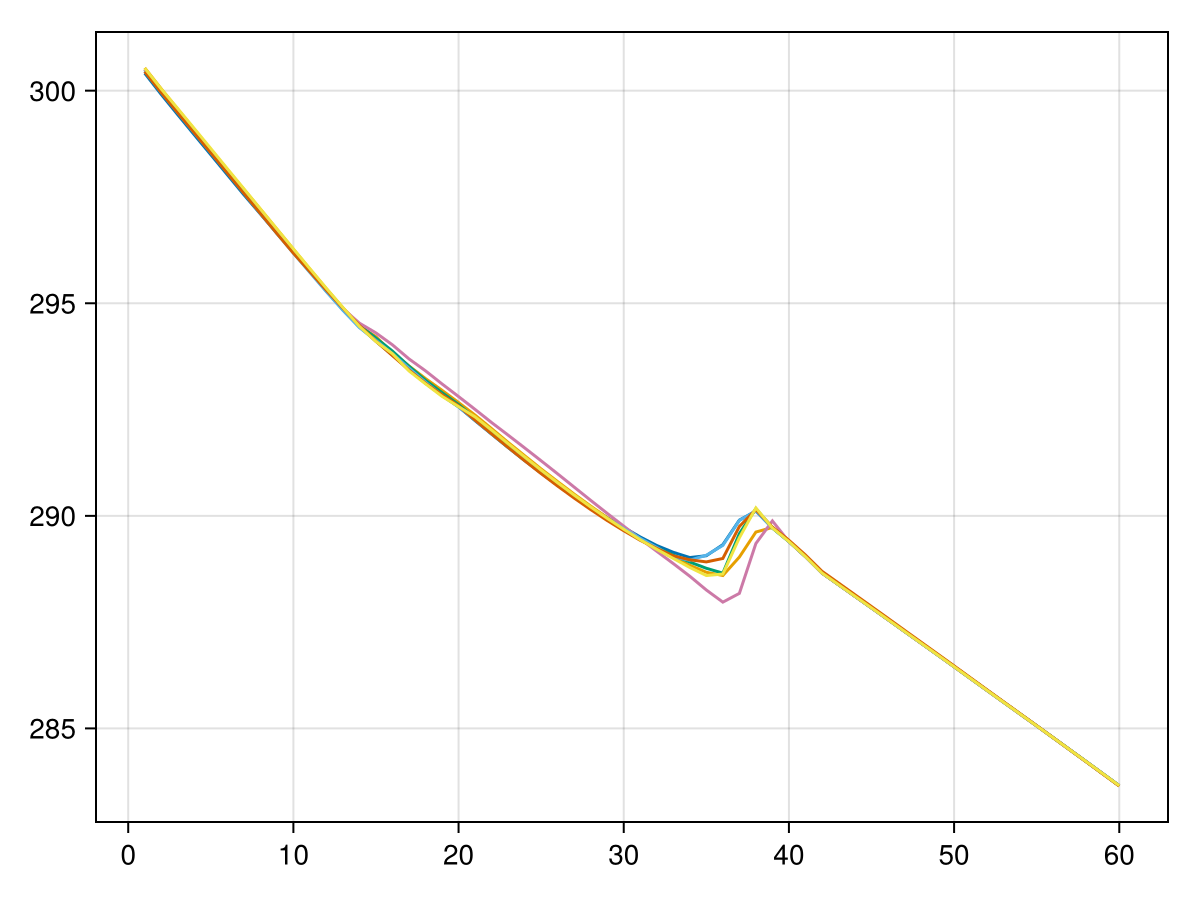

In [9]:
using CairoMakie
fig = Figure()
ax = Axis(fig[1, 1])
for i in 1:7
    lines!(ax, t[:, i])
end
fig

In [16]:
# examine eki object 
using EnsembleKalmanProcesses
using BlockDiagonals

t = JLD2.load("output/adpt_ta/iteration_000/eki_file.jld2")["single_stored_object"]

EnsembleKalmanProcess{Float64, Int64, Inversion, DataMisfitController{Float64, Matrix{Float64}, String}, DefaultAccelerator}(EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}[EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([-0.04660055818149992 -0.8146274861120039 … 0.5371090777830826 -0.19183393289889397; -1.6803297842121152 -1.1791079390407089 … -1.4214534078941734 -0.30467234062058796])], [300.5801696777344, 300.0848083496094, 299.60919189453125, 299.13671875, 298.66680908203125, 298.2015380859375, 297.7375183105469, 297.2685852050781, 296.7943115234375, 296.31939697265625  …  286.0845031738281, 285.81878662109375, 285.5520935058594, 285.2842712402344, 285.01690673828125, 284.7480773925781, 284.4805908203125, 284.2119445800781, 283.9433288574219, 283.6734313964844], [0.00026835773070357116 0.00026094913482666016 … 2.278704232594464e-5 3.230907168472186e-5; 0.00026094913482666016 0.000253750867443302 … 2.2156722479849122e-5 3.141313936794177e-5; … ; 2.278704

In [19]:
bm = Matrix(BlockDiagonal([rand(2, 3), ones(3, 2)]))


5×5 Matrix{Float64}:
 0.386085  0.377405  0.0423886  0.0  0.0
 0.226953  0.683254  0.171451   0.0  0.0
 0.0       0.0       0.0        1.0  1.0
 0.0       0.0       0.0        1.0  1.0
 0.0       0.0       0.0        1.0  1.0

In [38]:
t = JLD2.load("output/adpt_hus/iteration_007/eki_file.jld2")["single_stored_object"]

EnsembleKalmanProcess{Float64, Int64, Inversion, DataMisfitController{Float64, Matrix{Float64}, String}, DefaultAccelerator}(EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}[EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([-0.04660055818149992 -0.8146274861120039 … -0.39183927097320387 -1.07584116599902; -0.4915546945466472 -2.408784109462097 … -1.999595529616634 -2.5024737094418903]), EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([1.6198023802862542 1.6184102284355975 … 1.619802775066729 1.618235545133413; -1.1786229179990197 -1.178627804992168 … -1.176501761806409 -1.178750953445207]), EnsembleKalmanProcesses.DataContainers.DataContainer{Float64}([1.9943966098905586 1.9938616502154336 … 1.9940227682672318 1.994213060420231; -0.35784935765137094 -0.35715214567531317 … -0.35872308756423543 -0.3571099041317485])], [0.017265066504478455, 0.017003100365400314, 0.016920283436775208, 0.016885114833712578, 0.016869492828845978, 0.016869641840457916,

In [39]:
t.Δt

2-element Vector{Float64}:
 0.18177342421769932
 0.8182265757823006

In [40]:
t.get_u

ErrorException: type EnsembleKalmanProcess has no field get_u

In [49]:
readdir("output.")

5-element Vector{String}:
 ".DS_Store"
 "adpt_hus"
 "adpt_ta"
 "adpt_ta_hus"
 "prognostic_edmfx_bomex_column"

In [55]:
using ClimaCalibrate
t = load_object(joinpath(ClimaCalibrate.path_to_iteration("output/adpt_ta_hus", 7), "eki_file.jld2"))
cumsum(t.Δt)

7-element Vector{Float64}:
 9.696280665901051e-7
 5.495665540346063e-6
 9.013870365348634e-6
 1.3475959136525787e-5
 4.150231814343807e-5
 0.00014840591286055304
 0.00016052321087405347

In [57]:
using Revise
includet("floss_multi.jl")

In [69]:
# plot profiles and true variable 
using ClimaAnalysis
using Statistics
using Glob
H_perf("output/adpt_ta/iteration_001/member_001", ["ta"], cutoff=1, output_cov=false)

60-element Vector{Any}:
 300.5372f0
 300.05325f0
 299.58972f0
 299.12204f0
 298.65564f0
 298.1874f0
 297.71915f0
 297.2499f0
 296.78085f0
 296.31116f0
   ⋮
 285.89206f0
 285.61404f0
 285.3366f0
 285.05933f0
 284.77908f0
 284.49847f0
 284.21753f0
 283.9347f0
 283.65094f0

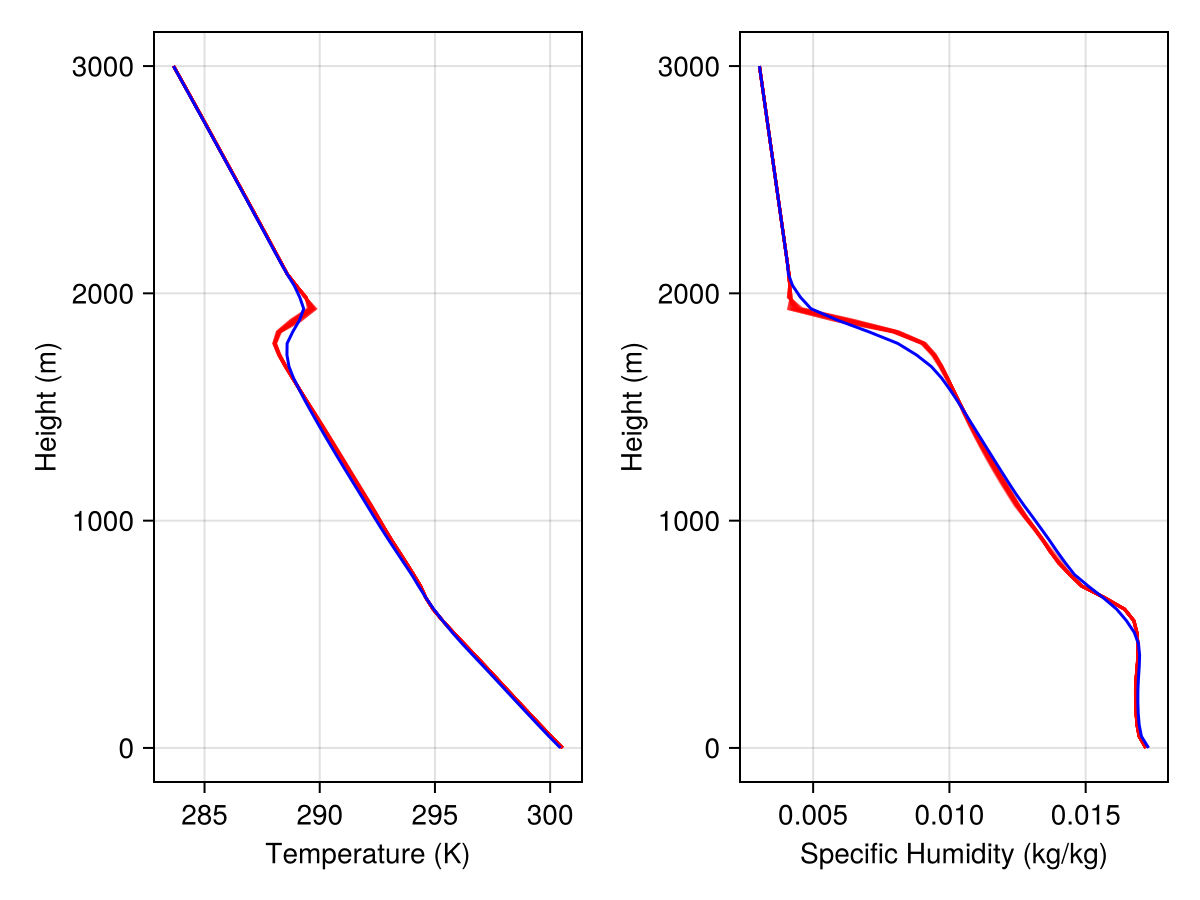

In [114]:
flist = Glob.glob("output/adpt_ta_hus/iteration_010/*/")
z = range(0, 3e3, length = 60)
# plot profiles and true variable
fig = Figure(figsize = (200, 100), title = "Final Ensemble Profiles")
ax1 = Axis(fig[1, 1], xlabel = "Temperature (K)", ylabel = "Height (m)")
for f in flist 
    lines!(ax1, H_perf(f, ["ta"], cutoff=1, output_cov=false),z, color = :red, alpha=.3)
end

# get true variable 
lines!(ax1, H_perf("output/prognostic_edmfx_bomex_column/", ["ta"], cutoff=1, output_cov=false), z, color = :blue)
band!(ax1, H_perf("output/prognostic_edmfx_bomex_column/", ["ta"], cutoff=1, output_cov=false), z)


# errorbars!(H_perf("output/prognostic_edmfx_bomex_column/", ["ta"], cutoff=1, output_cov=false), z, 
#             lowerrors, higherrors, whiskerwidth = 3, direction = :x)

ax2 = Axis(fig[1, 2], xlabel = "Specific Humidity (kg/kg)", ylabel = "Height (m)")
for f in flist 
    lines!(ax2, H_perf(f, ["hus"], cutoff=1, output_cov=false), z, color = :red, alpha=.3)
end

# get true variable
lines!(ax2, H_perf("output/prognostic_edmfx_bomex_column/", ["hus"], cutoff=1, output_cov=false),z , color = :blue)
fig

In [116]:
using LinearAlgebra
_, tcov = H_perf("output/prognostic_edmfx_bomex_column/", ["ta"], cutoff=1, output_cov=true)

(Any[300.44525f0, 299.94983f0, 299.47415f0, 299.0018f0, 298.53256f0, 298.06763f0, 297.60306f0, 297.13376f0, 296.6605f0, 296.19135f0  …  286.12833f0, 285.8552f0, 285.58115f0, 285.30615f0, 285.03134f0, 284.75543f0, 284.48053f0, 284.2046f0, 283.92862f0, 283.65152f0], [4.678275073772502e-5 4.948691275785677e-5 … 1.571855136717204e-5 2.0382305592647754e-5; 4.948691275785677e-5 5.237937731678803e-5 … 1.661200076341629e-5 2.153683453798294e-5; … ; 1.571855136717204e-5 1.661200076341629e-5 … 5.328029524639439e-6 6.906067483214429e-6; 2.0382305592647754e-5 2.153683453798294e-5 … 6.906067483214429e-6 8.961118888214421e-6])

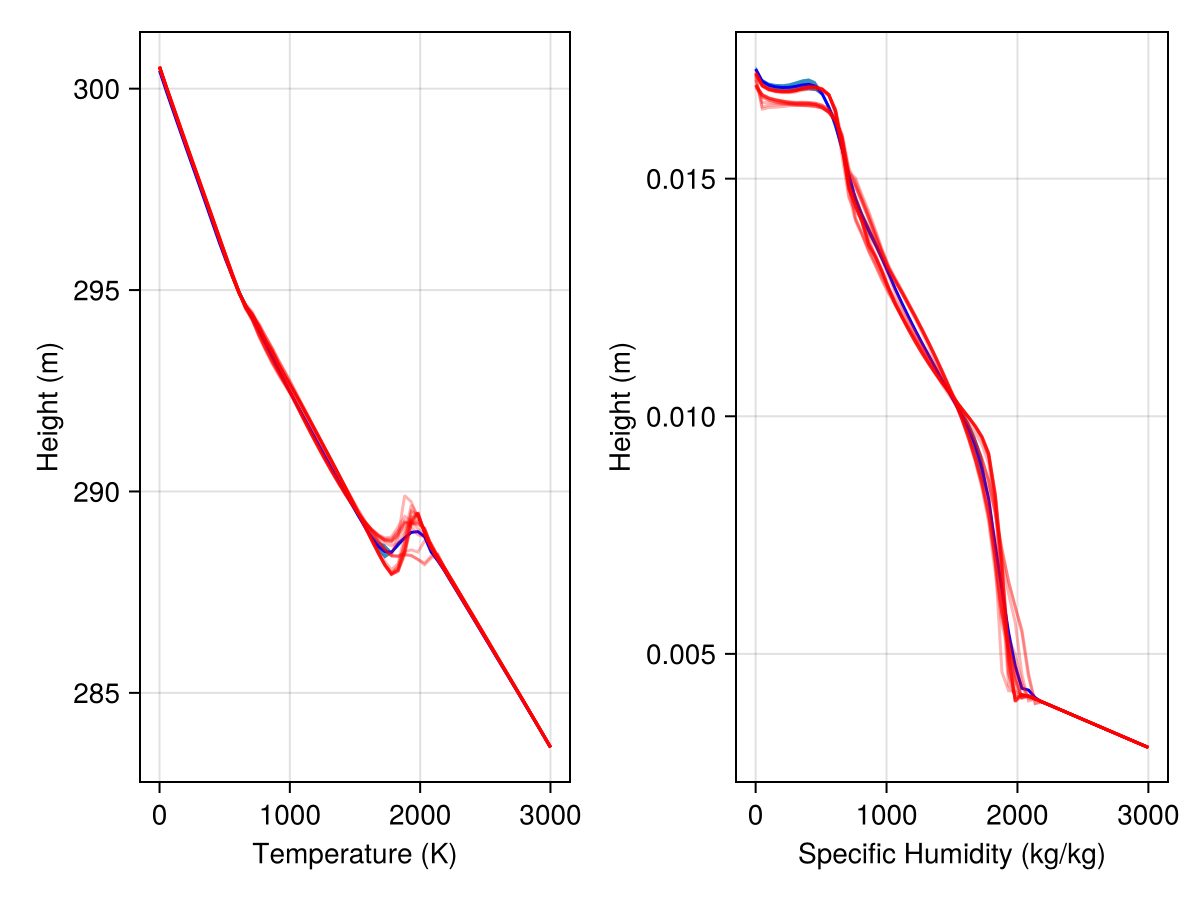

In [200]:
flist = Glob.glob("output/adpt_ta/iteration_003/*/")
z = range(0, 3e3, length = 60)
std_bars = 3
# plot profiles and true variable
fig = Figure(figsize = (200, 100), title = "Final Ensemble Profiles")
ax1 = Axis(fig[1, 1], xlabel = "Temperature (K)", ylabel = "Height (m)")

# get true variable 
temp_true, tcov = H_perf("output/prognostic_edmfx_bomex_column/", ["ta"], cutoff=1, output_cov=true)
t_error = sqrt.(diag(tcov))
band!(ax1, z, temp_true - std_bars * t_error, temp_true + std_bars * t_error)
lines!(ax1, z, temp_true, color = :blue)

for f in flist 
    lines!(ax1, z, H_perf(f, ["ta"], cutoff=1, output_cov=false), color = :red, alpha=.3)
end


ax2 = Axis(fig[1, 2], xlabel = "Specific Humidity (kg/kg)", ylabel = "Height (m)")
temp_true, tcov = H_perf("output/prognostic_edmfx_bomex_column/", ["hus"], cutoff=1, output_cov=true)
t_error = sqrt.(diag(tcov))
band!(ax2, z, temp_true - std_bars * t_error, temp_true + std_bars * t_error)
lines!(ax2, z, temp_true, color = :blue)
for f in flist 
    lines!(ax2, z, H_perf(f, ["hus"], cutoff=1, output_cov=false), color = :red, alpha=.3)
end

# get true variable

fig

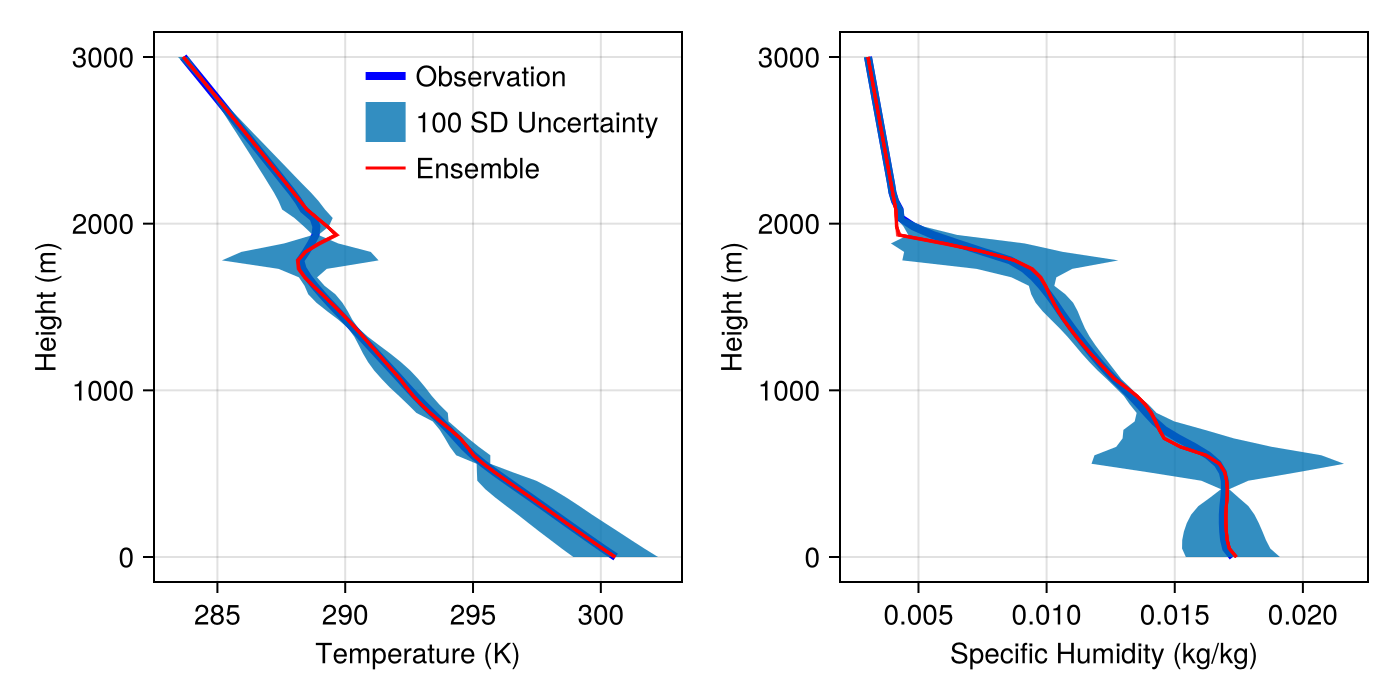

In [285]:
flist = Glob.glob("output/adpt_ta_hus_clw_wa_hur_cl/iteration_006/*/")
z = range(0, 3e3, length = 60)
std_bars = 100
# plot profiles and true variable
fig = Figure(size = (700, 350), title = "Final Ensemble Profiles")
ax1 = Axis(fig[1, 1], xlabel = "Temperature (K)", ylabel = "Height (m)")
temp_true, tcov = H_perf("output/prognostic_edmfx_bomex_column/", ["ta"], cutoff=50, output_cov=true)
lines!(ax1, temp_true, z, color = :blue, linewidth = 4, label = "Observation")

band!(Point2f.(temp_true - std_bars * sqrt.(diag(tcov)), z), Point2f.(temp_true + std_bars * sqrt.(diag(tcov)), z), alpha=.5, label = "100 SD Uncertainty")

for (ind, f) in enumerate(flist)
    if ind ==1 
        lines!(ax1, H_perf(f, ["ta"], cutoff=40, output_cov=false), z, color = :red, alpha=.3, label = "Ensemble")
    else
        lines!(ax1, H_perf(f, ["ta"], cutoff=40, output_cov=false), z, color = :red, alpha=.3)
    end
    #lines!(ax1, H_perf(f, ["ta"], cutoff=1, output_cov=false),z, color = :red, alpha=.3)
end


ax2 = Axis(fig[1, 2], xlabel = "Specific Humidity (kg/kg)", ylabel = "Height (m)")
temp_true, tcov = H_perf("output/prognostic_edmfx_bomex_column/", ["hus"], cutoff=50, output_cov=true)
lines!(ax2, temp_true, z, color = :blue, linewidth = 4)
band!(Point2f.(temp_true - std_bars * sqrt.(diag(tcov)), z), Point2f.(temp_true + std_bars * sqrt.(diag(tcov)), z), alpha=.5)

for f in flist 
    lines!(ax2, H_perf(f, ["hus"], cutoff=40, output_cov=false), z, color = :red, alpha=.3)
end
axislegend(ax1, framevisible = false, position = :rt)
# save figure 
save("plots/ensemble_profile_error.png", fig)
fig

In [287]:
omean, ocov = H_perf("output/prognostic_edmfx_bomex_column", ["ta"], cutoff=40, output_cov=true)

(Any[300.55246f0, 300.05743f0, 299.58206f0, 299.1098f0, 298.64014f0, 298.17517f0, 297.7113f0, 297.2423f0, 296.76837f0, 296.2953f0  …  286.08893f0, 285.82104f0, 285.5546f0, 285.2871f0, 285.01877f0, 284.7465f0, 284.47644f0, 284.2045f0, 283.93182f0, 283.6603f0], [0.0003144400151601259 0.00030759311630390584 … 2.4042465156526305e-5 3.317296432214789e-5; 0.00030759311630390584 0.0003061421056432847 … 2.372022754570935e-5 3.272816684329882e-5; … ; 2.4042465156526305e-5 2.372022754570935e-5 … 4.525094169930632e-6 2.559646873123711e-6; 3.317296432214789e-5 3.272816684329882e-5 … 2.559646873123711e-6 6.2012885851983055e-6])

In [309]:
omean_trunc = H_perf2("output/prognostic_edmfx_bomex_column", ["ta"], output_cov=false)

60-element Vector{Any}:
 300.827f0
 300.33075f0
 299.85403f0
 299.38055f0
 298.90894f0
 298.44122f0
 297.97598f0
 297.5073f0
 297.03177f0
 296.55167f0
   ⋮
 285.6844f0
 285.44345f0
 285.19864f0
 284.95227f0
 284.7003f0
 284.45386f0
 284.2047f0
 283.95447f0
 283.70685f0

In [299]:
#emean, ecov = H_perf("output/adpt_ta_hus_clw_wa_hur_cl/iteration_006/member_002", ["ta"], cutoff=1, output_cov=true)
emean = H_perf(flist[1], ["ta"], cutoff=40, output_cov=false)

60-element Vector{Any}:
 300.5568f0
 300.0614f0
 299.58743f0
 299.117f0
 298.65042f0
 298.19f0
 297.72842f0
 297.2601f0
 296.78708f0
 296.3135f0
   ⋮
 285.8359f0
 285.5669f0
 285.29898f0
 285.0319f0
 284.7607f0
 284.48846f0
 284.2169f0
 283.9445f0
 283.66953f0

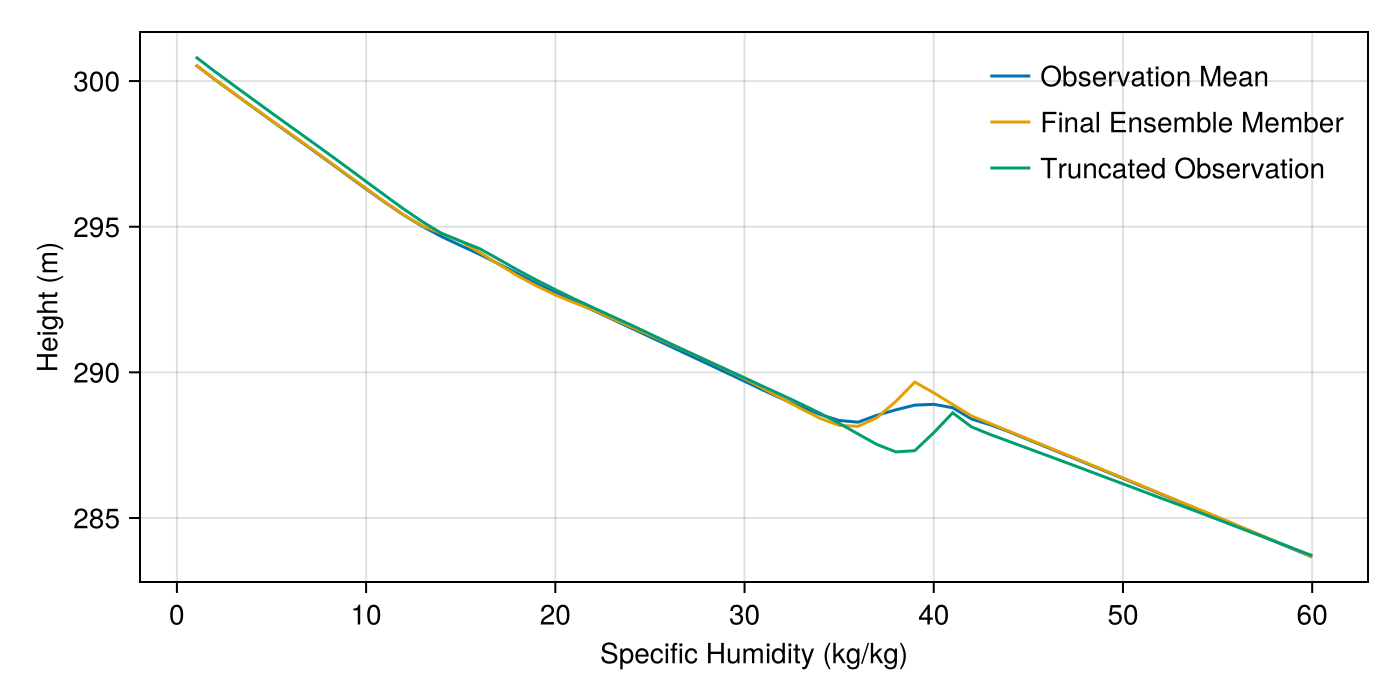

In [311]:
fig = Figure(size = (700, 350), title = "Final Ensemble Profiles")
ax = Axis(fig[1, 1], xlabel = "Specific Humidity (kg/kg)", ylabel = "Height (m)")
lines!(omean, label = "Observation Mean")
lines!(emean, label = "Final Ensemble Member")
lines!(omean_trunc, label = "Truncated Observation")
axislegend(ax, framevisible = false, position = :rt)
fig

In [308]:
function H_perf2(dir::String, short_names; noise = 0.01, obs_length = 40, cutoff=240, cutoff_max = 264, output_cov = true)
    """Single Variable Calibration"""
	simdir = ClimaAnalysis.SimDir(joinpath(dir, "output_active")) # allow for flexibility in choosing data directory
    means = []
    covs = Vector{AbstractMatrix{Float64}}()
    for short_name in short_names
        obs = ClimaAnalysis.get(simdir; short_name = short_name, period = "10m")
    
        # compute data
        #return mean(obs.data[cutoff:cutoff_max, :, :, :], dims=(2,3))
        obs_dat = reshape(mean(obs.data[cutoff:cutoff_max, :, :, :], dims=(2,3)), cutoff_max - cutoff+1, size(obs.data)[end])
        # compute time mean
        obs_mean = vec(mean(obs_dat, dims=1))

        # normalize 
        #obs_mean = (obs_mean .- mean(obs_mean)) ./ std(obs_mean)
        # compute covariance if required
        append!(means, obs_mean)
        if output_cov
            # chunk the longrun observation by the same number of windows as the simulation (need to hand pick this value based on length)
            #obs_cov = cov([vec(mean(obs_dat[i:i+obs_length, :], dims=1)) for i in 1:Integer(floor(size(obs_dat)[1]/obs_length))])
            obs_cov = cov(obs_dat)
            # ensure positive definiteness
            #if !isposdef(obs_cov)
            obs_cov = obs_cov + (abs(minimum(eigvals(obs_cov)))+maximum(diag(obs_cov))*.001) .* I
            #end
            push!(covs, obs_cov)
        end
            
    end
    if output_cov 
        #obs_cov = Matrix(I, length(means), length(means))
        obs_covs = Matrix(BlockDiagonal(covs))
        return means, obs_covs
    else
        return means
    end
end	

H_perf2 (generic function with 1 method)